# Predicting Adoption Speed

## Introduction

The purpose of this notebook is to provide an analysis of which types of pets have the toughest time getting adopted. In this analysis we are only studying the adoptions of Dogs and cats.

## Business Understanding

Shelters need to know which pets take the longest time to get adopted, so that they can focus on pushing potential adopters towards those pets.

+ __Stakeholder:__ ASPCA 


+ __Importance of Predictions:__ Correctly identifying which pets will have trouble getting adopted can save pets from a lifetime in a cage or getting put to sleep in the worst case scenario.


+ __Deliverable:__ An analysis of the adoptability of different types of dogs and cats


+ __Type of model:__ An interpretable multiclassification model that can be used in conjunction with domain knowledge to boost the accuracy of predictions on a pet's adoptability.

## Context

+ __False Positive:__ Predicting that a pet will get adopted within a month when it actually takes longer.


+ __False negative:__ Predicting that a pet will take longer than a month when  get adopted later than it actually gets adopted


+ __Which is Worse:__ False positive is worse because we would end up ignoring pets that need extra help getting adopted.

+ __Metric:__ 
    - __Precision__
    - Accuracy

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer, OrdinalEncoder, RobustScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, roc_auc_score, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

import warnings

warnings.filterwarnings('ignore')

## Data Understanding

- I cleaned most of the data in the EDA notebook and that data is also included in this repository
- Most of the pets in this dataset have been adopted, thats why the focus is on adoption speed
- The target variable is 'duration of stay' which will be divided into 4 categories

These imports are saved csv files that I made after extensively cleaning the data in the EDA notebook.

In [2]:
cat_df = pd.read_csv('data/cat_df.csv')
dog_df = pd.read_csv('data/dog_df.csv')

## Data Exploration recap

In [3]:
cat_df['sexname'].value_counts()

Female     3598
Male       3341
Unknown     133
Name: sexname, dtype: int64

In [4]:
dog_df['sexname'].value_counts()

Male       2454
Female     1996
Unknown      20
Name: sexname, dtype: int64

The sex of both dogs and cats are pretty balanced

In [5]:
cat_df['age(months)'].value_counts()

6.0    201
1.0    162
3.0    112
2.0     79
4.0     65
5.0     58
Name: age(months), dtype: int64

In [6]:
dog_df['age(months)'].value_counts()

5.0    29
6.0    27
4.0    12
1.0     9
3.0     2
2.0     2
Name: age(months), dtype: int64

Not many puppies in this dataset, but we have almost 600 kittens.

In [7]:
cat_df['age(years)'].value_counts()

1.0     2580
2.0     1256
3.0     1052
0.0      677
4.0      390
5.0      269
6.0      171
7.0      160
8.0      116
10.0      96
9.0       61
11.0      57
12.0      45
13.0      39
14.0      30
15.0      26
16.0      26
17.0      12
18.0       6
19.0       3
Name: age(years), dtype: int64

In [8]:
dog_df['age(years)'].value_counts()

1.0     982
2.0     728
3.0     644
4.0     445
5.0     293
6.0     205
8.0     180
7.0     180
9.0     145
11.0    123
10.0    120
12.0    103
0.0      81
14.0     78
13.0     77
15.0     38
16.0     30
17.0      8
18.0      8
19.0      2
Name: age(years), dtype: int64

Most of the pets in this dataset are on the younger side of the scale.

### Prepare Dog Data for modeling

In [9]:
dog_df.head()

,Unnamed: 0,id,intakedate,intakereason,istransfer,identichipnumber,animalname,breedname,basecolour,speciesname,animalage,sexname,location,movementdate,movementtype,returndate,puttosleep,age(months),age(years),duration of stay
0,12,46238,2016-10-09 00:00:00,Abandoned,False,981020019070093,Tennessee,Heeler,Black and Brown,Dog,5 years 7 months,Male,Special Care Dogs,2018-02-14 00:00:00,Adoption,NaN,False,NaN,5.0,493.0
1,15,46693,2016-11-21 00:00:00,Abandoned,False,981020017897009,Baby,Pitbull,White,Dog,5 years 9 months,Male,Adoptable Dogs,2017-04-07 00:00:00,Adoption,NaN,False,NaN,5.0,137.0
2,19,47146,2017-01-17 00:00:00,Abandoned,False,981020021063793,Dinah,Labrador Retriever,Black,Dog,5 years 6 months,Female,Foster,2017-04-01 00:00:00,Adoption,NaN,False,NaN,5.0,74.0
3,27,47239,2017-01-27 00:00:00,Abandoned,False,981020021070452,Maria,NaN,Black and Brown,Dog,3 years 5 months,Female,Foster,2017-04-01 00:00:00,Adoption,NaN,False,NaN,3.0,64.0
4,33,47319,2017-02-05 00:00:00,other,False,NaN,Louise Vada,Pitbull,Black,Dog,4 years 5 months,Female,Stray Dogs Theta,2017-04-05 00:00:00,Reclaimed,NaN,False,NaN,4.0,59.0


In [10]:
dog_df['age(months)'].describe()

count    81.000000
mean      4.617284
std       1.569776
min       1.000000
25%       4.000000
50%       5.000000
75%       6.000000
max       6.000000
Name: age(months), dtype: float64

In [11]:
dog_df['movementtype'].value_counts()

Adoption     2841
Reclaimed    1487
Transfer      107
Foster         34
Escaped         1
Name: movementtype, dtype: int64

This model is gonna focus on the dogs that got adopted, and predict how long it takes 

In [12]:
dog_model_data = dog_df[dog_df['movementtype'] == 'Adoption']

In [13]:
dog_model_data['duration of stay'].isna().sum()

0

In [14]:
dog_model_data.describe()

,Unnamed: 0,id,age(months),age(years),duration of stay
count,2841.000000,2841.000000,65.000000,2841.000000,2841.000000
mean,8698.644843,62603.009152,5.061538,3.689194,53.449490
std,5244.246966,4842.666952,0.899252,3.221766,118.125138
min,12.000000,46238.000000,2.000000,0.000000,1.000000
25%,4123.000000,58835.000000,5.000000,1.000000,10.000000
50%,8203.000000,62340.000000,5.000000,3.000000,18.000000
75%,12722.000000,66193.000000,6.000000,5.000000,41.000000
max,18667.000000,71690.000000,6.000000,18.000000,1443.000000


Now I want to categorize my target column into these 2 values.

- 0 — Pet took more than 30 days to get adopted after being listed.
- 1 — Pet took less than a month to get adopted.

In [15]:
dog_model_data['duration of stay'][dog_model_data['duration of stay'] <= 30] = 1
dog_model_data['duration of stay'][dog_model_data['duration of stay'] > 30] = 0

In [16]:
dog_model_data['duration of stay'].value_counts()

1.0    1910
0.0     931
Name: duration of stay, dtype: int64

In [17]:
 dog_model_data.head()

,Unnamed: 0,id,intakedate,intakereason,istransfer,identichipnumber,animalname,breedname,basecolour,speciesname,animalage,sexname,location,movementdate,movementtype,returndate,puttosleep,age(months),age(years),duration of stay
0,12,46238,2016-10-09 00:00:00,Abandoned,False,981020019070093,Tennessee,Heeler,Black and Brown,Dog,5 years 7 months,Male,Special Care Dogs,2018-02-14 00:00:00,Adoption,NaN,False,NaN,5.0,0.0
1,15,46693,2016-11-21 00:00:00,Abandoned,False,981020017897009,Baby,Pitbull,White,Dog,5 years 9 months,Male,Adoptable Dogs,2017-04-07 00:00:00,Adoption,NaN,False,NaN,5.0,0.0
2,19,47146,2017-01-17 00:00:00,Abandoned,False,981020021063793,Dinah,Labrador Retriever,Black,Dog,5 years 6 months,Female,Foster,2017-04-01 00:00:00,Adoption,NaN,False,NaN,5.0,0.0
3,27,47239,2017-01-27 00:00:00,Abandoned,False,981020021070452,Maria,NaN,Black and Brown,Dog,3 years 5 months,Female,Foster,2017-04-01 00:00:00,Adoption,NaN,False,NaN,3.0,0.0
7,50,47502,2017-02-27 00:00:00,other,False,981020015101070,Zoey,Pitbull,Grey and White,Dog,5 years 4 months,Female,Stray Dogs Beta,2017-06-01 00:00:00,Adoption,NaN,False,NaN,5.0,0.0


In [18]:
dog_model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2841 entries, 0 to 4467
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        2841 non-null   int64  
 1   id                2841 non-null   int64  
 2   intakedate        2841 non-null   object 
 3   intakereason      2841 non-null   object 
 4   istransfer        2841 non-null   bool   
 5   identichipnumber  2838 non-null   object 
 6   animalname        2841 non-null   object 
 7   breedname         2840 non-null   object 
 8   basecolour        2841 non-null   object 
 9   speciesname       2841 non-null   object 
 10  animalage         2841 non-null   object 
 11  sexname           2841 non-null   object 
 12  location          2841 non-null   object 
 13  movementdate      2841 non-null   object 
 14  movementtype      2841 non-null   object 
 15  returndate        55 non-null     object 
 16  puttosleep        2841 non-null   bool   


Breedname is missing one value so i will fill it with 'Other'

In [19]:
dog_model_data['breedname'] = dog_model_data['breedname'].fillna('Other')

The months that have missing values means that age will be dictated by the years column, so we can fill the rest of the months column with zeroes, I did the same thing for the years column in my data cleaning notebook before saving the csv. Will be more organized in final notebook.

In [20]:
dog_model_data['age(months)'] = dog_model_data['age(months)'].fillna(0)

### Prepare Cat data for Modeling

In [21]:
cat_df.head()

,Unnamed: 0,id,intakedate,intakereason,istransfer,identichipnumber,animalname,breedname,basecolour,speciesname,animalage,sexname,location,movementdate,movementtype,returndate,puttosleep,age(months),age(years),duration of stay
0,14,46437,2016-10-26 00:00:00,Abandoned,False,981020017650993,Nova,Domestic Long Hair,Black,Cat,12 years 3 months,Female,Stray Cats,2017-04-07 00:00:00,Adoption,02/09/2018 12:00:00 AM,True,NaN,12.0,163.0
1,17,47120,2017-01-11 00:00:00,Abandoned,False,981020021072899,Vivian,Other,Other,Cat,6 years 5 months,Female,Foster,2017-05-13 00:00:00,Adoption,NaN,False,NaN,6.0,122.0
2,26,47198,2017-01-22 00:00:00,Abandoned,False,981020021020775,Mama Mia,Domestic Short Hair,Grey and White,Cat,4 years 10 months,Female,Adoptable Cat Glass Colony,2017-06-22 00:00:00,Adoption,NaN,False,NaN,4.0,151.0
3,29,47248,2017-01-27 00:00:00,Abandoned,False,981020021068759,Mr. T,Other,Black,Cat,11 years 7 months,Male,Foster,2017-06-02 00:00:00,Adoption,NaN,False,NaN,11.0,126.0
4,30,47277,2017-01-31 00:00:00,Abandoned,False,981020021046006,Coraline,Domestic Short Hair,Brown and Black,Cat,5 years 5 months,Female,Adoptable Cat Glass Colony,2017-04-05 00:00:00,Adoption,NaN,False,NaN,5.0,64.0


In [22]:
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7072 entries, 0 to 7071
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        7072 non-null   int64  
 1   id                7072 non-null   int64  
 2   intakedate        7072 non-null   object 
 3   intakereason      7072 non-null   object 
 4   istransfer        7072 non-null   bool   
 5   identichipnumber  6170 non-null   object 
 6   animalname        7072 non-null   object 
 7   breedname         7072 non-null   object 
 8   basecolour        7072 non-null   object 
 9   speciesname       7072 non-null   object 
 10  animalage         7072 non-null   object 
 11  sexname           7072 non-null   object 
 12  location          7072 non-null   object 
 13  movementdate      7072 non-null   object 
 14  movementtype      7072 non-null   object 
 15  returndate        200 non-null    object 
 16  puttosleep        7072 non-null   bool   


In [23]:
cat_df['breedname'].value_counts()

Domestic Short Hair     5811
Domestic Medium Hair     560
Domestic Long Hair       419
Siamese                  121
Manx                      52
Other                     47
Unknown                   29
Bengal                    11
Maine Coon                 9
Oriental Shorthair         7
Calico                     6
Name: breedname, dtype: int64

In [24]:
cat_df['movementtype'].value_counts()

Adoption            5945
Reclaimed            405
Transfer             356
Foster               326
Released To Wild      29
Stolen                 6
Escaped                5
Name: movementtype, dtype: int64

In [25]:
dog_df['breedname'].value_counts()

Labrador Retriever        708
Bully Breed               544
Beagle                    380
Terrier                   363
Hound                     315
Other                     312
German Shepherd           289
Chihuahua                 236
Pitbull                   207
Husky                     140
Border Collie             115
Boxer                      90
Mix                        65
Golden Retriever           65
Coonhound                  54
Great Pyrenees             53
Rottweiler                 52
Australian Shepherd        37
Heeler                     36
Cattle Dog                 33
Shih Tzu                   31
Mastiff                    31
Dachshund                  29
Pomeranian                 23
Miniature Pinscher         21
American Bulldog           19
Mountain Cur               18
Spaniel                    18
Pug                        17
Poodle                     16
Shiba Inu                  14
Schnauzer                  13
Cocker Spaniel             12
Great Dane

In [26]:
dog_df['basecolour'].value_counts()

Black and White           590
Black                     547
Tricolour                 289
Black and Tan             285
Brown and White           281
Brown                     255
Tan                       251
White and Tan             241
Black and Brown           238
Red                       196
Brindle                   182
Other                     180
White                     171
Grey and White             97
Cream                      96
Brindle and White          87
Fawn                       76
Golden                     74
Red and White              72
Grey                       54
Blue                       54
Black, Brown and White     48
Black and grey             31
Blue merle                 31
White and Brindle          22
Black merle                22
Name: basecolour, dtype: int64

In [27]:
cat_model_data = cat_df[cat_df['movementtype'] == 'Adoption']

I am focusing on the pets that got adopted and analyzing how long it took.

In [28]:
cat_model_data.describe()

,Unnamed: 0,id,age(months),age(years),duration of stay
count,5945.000000,5945.000000,391.000000,5945.000000,5945.000000
mean,9754.459378,63577.247098,4.856777,2.477712,51.057359
std,5320.087394,4748.933416,1.300867,2.501994,83.680666
min,14.000000,46437.000000,2.000000,0.000000,1.000000
25%,5365.000000,59873.000000,4.000000,1.000000,15.000000
50%,10203.000000,64000.000000,5.000000,2.000000,34.000000
75%,14281.000000,67472.000000,6.000000,3.000000,59.000000
max,18663.000000,71663.000000,6.000000,18.000000,1220.000000


In [29]:
cat_model_data['duration of stay'][cat_model_data['duration of stay'] <= 30] = 1
cat_model_data['duration of stay'][cat_model_data['duration of stay'] > 30] = 0

In [30]:
cat_model_data['duration of stay'].value_counts()

0.0    3232
1.0    2713
Name: duration of stay, dtype: int64

In [31]:
cat_model_data['age(months)'] = cat_model_data['age(months)'].fillna(0)

#### Categorize the target column the same way that I did for the dog dataframe

## Modeling

In [32]:
def evaluate(estimator, X_tr, X_te, y_tr, y_te, roc_auc='skip'):

    tr_preds = estimator.predict(X_tr)
    te_preds = estimator.predict(X_te)
    
    # output needed for roc_auc_score
    if roc_auc == 'skip': # skips calculating the roc_auc_score
        train_out = False
        test_out = False
    elif roc_auc == 'dec': 
        train_out = estimator.decision_function(X_train)
        test_out = estimator.decision_function(X_test)
    elif roc_auc == 'proba': 
        train_out = estimator.predict_proba(X_train)[:, 1] # proba for the 1 class
        test_out = estimator.predict_proba(X_test)[:, 1]
    else:
        raise Exception("The value for roc_auc should be 'skip', 'dec' or 'proba'")    
    
    print("Training Scores:")
    print(f"Train Accuracy: {accuracy_score(y_tr, tr_preds)}")
    print(f"Train Precision: {precision_score(y_tr, tr_preds)}")
    print(f"Train Recall: {recall_score(y_tr, tr_preds)}")
    print(f"Train F1-Score: {f1_score(y_tr, tr_preds)}")
    if type(train_out) == np.ndarray: # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_train, train_out)}")
        
    print("*" * 10)
    print("Testing Scores:")
    print(f"Test Accuracy: {accuracy_score(y_te, te_preds)}")
    print(f"Test Precision: {precision_score(y_te, te_preds)}")
    print(f"Test Recall: {recall_score(y_te, te_preds)}")
    print(f"Test F1-Score: {f1_score(y_te, te_preds)}")
    if type(test_out) == np.ndarray: # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_test, test_out)}")    
    
    # Plot confusion matrix for test set
    plot_confusion_matrix(estimator, X_te, y_te, normalize='true')


### First Simple Model for Dog predictions

In [33]:
dog_model_data.columns

Index(['Unnamed: 0', 'id', 'intakedate', 'intakereason', 'istransfer',
       'identichipnumber', 'animalname', 'breedname', 'basecolour',
       'speciesname', 'animalage', 'sexname', 'location', 'movementdate',
       'movementtype', 'returndate', 'puttosleep', 'age(months)', 'age(years)',
       'duration of stay'],
      dtype='object')

In [34]:
used_cols = ['age(months)', 'age(years)', 'sexname', 'basecolour', 'breedname', 'intakereason']

In [35]:
X = dog_model_data[used_cols]
y = dog_model_data['duration of stay']

X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.15, random_state=42)

In [36]:
#perform a second train_test_split
X = X_train
y = y_train

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [37]:
# Use a for loop to seperate numrical and categorical columns
num_cols =[]
cat_cols = []

for c in used_cols:
    if X[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    else:
        cat_cols.append(c)

In [38]:
print(num_cols)
print(cat_cols)

['age(months)', 'age(years)']
['sexname', 'basecolour', 'breedname', 'intakereason']


Create a pipeline to One hot encode categorical values, and scale numerical columns in case we use models that require scaling.

In [39]:
hotencoder = OneHotEncoder(handle_unknown='ignore')
cat_transformer = make_pipeline(hotencoder)

scaler = StandardScaler()
num_transformer = make_pipeline(scaler)

In [40]:
# Package our encoder into a Column Transformer
preprocessor = ColumnTransformer(
    transformers=[('cat', cat_transformer, cat_cols), 
                  ('num', num_transformer, num_cols)], remainder='passthrough')

In [41]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['sexname', 'basecolour', 'breedname',
                                  'intakereason']),
                                ('num',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['age(months)', 'age(years)'])])

In [42]:
X_tr_transformed = preprocessor.fit_transform(X_train)

Our transformed data now has 86 columns.

In [43]:
X_tr_transformed.shape

(1810, 85)

In [44]:
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['sexname', 'basecolour', 'breedname',
                                  'intakereason']),
                                ('num',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['age(months)', 'age(years)'])])

In [45]:
dt_simple_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

In [46]:
cross_validate(dt_simple_model, X_train, y_train, return_train_score='true')


{'fit_time': array([0.03237009, 0.02394509, 0.02357388, 0.03197861, 0.02402616]),
 'score_time': array([0.00765419, 0.01559258, 0.00799274, 0.00800014, 0.00798416]),
 'test_score': array([0.61325967, 0.59116022, 0.59392265, 0.59668508, 0.56353591]),
 'train_score': array([0.95787293, 0.96063536, 0.96339779, 0.95994475, 0.96685083])}

In [47]:
dt_simple_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier', DecisionTreeClassifier())])

Training Scores:
Train Accuracy: 0.9558011049723757
Train Precision: 0.9797125950972105
Train Recall: 0.9539094650205762
Train F1-Score: 0.9666388657214345
**********
Testing Scores:
Test Accuracy: 0.5993377483443708
Test Precision: 0.7105263157894737
Test Recall: 0.6716417910447762
Test F1-Score: 0.690537084398977


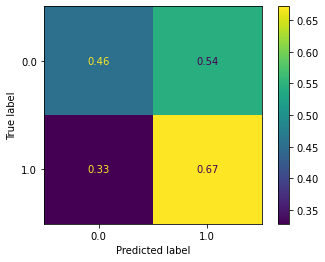

In [48]:
evaluate(dt_simple_model, X_train, X_test, y_train, y_test)

Model is severely overfit, some tuning or different model choice is needed.

###  Simple Decision Tree Model Evaluation

Remember:

- 0 — Pet took more than 30 days to get adopted after being listed.
- 1 — Pet took less than a month to get adopted.

- The model is pretty good at predicting if a dog will take longer than 30 days to adopt
- It is a correct at predicting dogs that take longer than a month almost 50 percent of the time.

### Cat simple model

In [49]:
X = cat_model_data[used_cols]
y = cat_model_data['duration of stay']
# We add cat to the end of our variables so that we dont get mixed up with the dog model data
X_train_cat, X_hold_cat, y_train_cat, y_hold_cat = train_test_split(X, y, test_size=0.15, random_state=42)

In [50]:
#perform a second train_test_split
X = X_train_cat
y = y_train_cat

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X, y, random_state=42)

In [51]:
preprocessor_cat = preprocessor

In [52]:
X_tr_transformed_cat = preprocessor_cat.fit_transform(X_train_cat)
X_tr_transformed_cat.shape

(3789, 49)

Our cat training data has 3789 rows and 85 columns

In [53]:
preprocessor_cat.fit(X_train_cat)

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['sexname', 'basecolour', 'breedname',
                                  'intakereason']),
                                ('num',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['age(months)', 'age(years)'])])

In [54]:
cat_dt_simple_model = Pipeline(steps=[
    ('preprocessor', preprocessor_cat),
    ('classifier', DecisionTreeClassifier())
])

In [55]:
cross_validate(cat_dt_simple_model, X_train_cat, y_train_cat, return_train_score='true')

{'fit_time': array([0.04002237, 0.04125857, 0.03999996, 0.04000139, 0.04000378]),
 'score_time': array([0.00798941, 0.00800419, 0.0080018 , 0.00800443, 0.00800157]),
 'test_score': array([0.54485488, 0.54617414, 0.56728232, 0.53825858, 0.57331572]),
 'train_score': array([0.79214781, 0.79115803, 0.78752887, 0.78785879, 0.7823219 ])}

In [56]:
cat_dt_simple_model.fit(X_train_cat, y_train_cat)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier', DecisionTreeClassifier())])

Training Scores:
Train Accuracy: 0.7735550277117973
Train Precision: 0.8469551282051282
Train Recall: 0.6131090487238979
Train F1-Score: 0.7113055181695828
**********
Testing Scores:
Test Accuracy: 0.5632911392405063
Test Precision: 0.53125
Test Recall: 0.38235294117647056
Test F1-Score: 0.44466800804828976


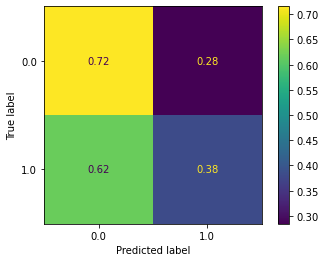

In [57]:
evaluate(cat_dt_simple_model, X_train_cat, X_test_cat, y_train_cat, y_test_cat)

### Simple Cat decision tree evaluation

- Better than expected at predicting cats that take longer than a month to get adopted.(which is great, thats the main point of this analysis)
- Its is not too good at classifying cats that get adopted in less than a month. 
- Overfit but our false positive rate is pretty low

### Random forest Models

#### Cat Model

In [58]:
cat_forest_model = Pipeline(steps=[
    ('preprocessor', preprocessor_cat),
    ('classifier', RandomForestClassifier())
])

In [59]:
cross_validate(cat_forest_model, X_train_cat, y_train_cat, return_train_score=True)

{'fit_time': array([1.28212929, 1.31251764, 1.34364128, 1.20690703, 1.00050592]),
 'score_time': array([0.0320015 , 0.04000521, 0.03200531, 0.03200388, 0.02400374]),
 'test_score': array([0.54485488, 0.55804749, 0.59102902, 0.54617414, 0.5653897 ]),
 'train_score': array([0.79214781, 0.79115803, 0.78719894, 0.78752887, 0.78199208])}

In [60]:
cat_forest_model.fit(X_train_cat, y_train_cat)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier', RandomForestClassifier())])

Training Scores:
Train Accuracy: 0.7735550277117973
Train Precision: 0.7982093663911846
Train Recall: 0.6722737819025522
Train F1-Score: 0.7298488664987406
ROC-AUC: 0.5362527233115468
**********
Testing Scores:
Test Accuracy: 0.569620253164557
Test Precision: 0.5341365461847389
Test Recall: 0.4602076124567474
Test F1-Score: 0.4944237918215614
ROC-AUC: 0.5494064331806315


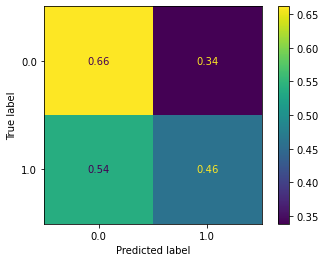

In [61]:
evaluate(cat_forest_model, X_train_cat, X_test_cat, y_train_cat, y_test_cat, 'proba')

#### Simple Random Forest Evaluation


- It performs slightly worse than our decision tree model on test data
- Its alot better at predicting which cats get adopted in less than a month. 
- It is couple points worse at predicting the cats that take longer to get adopted thant the decision tree resulting in a higher false positive rate.

#### Dog Forest Model

In [62]:
dog_forest_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

In [63]:
cross_validate(dog_forest_model, X_train, y_train, return_train_score=True)

{'fit_time': array([0.45743513, 0.47102547, 0.48114371, 0.46405268, 0.4560473 ]),
 'score_time': array([0.02400279, 0.01573277, 0.0237751 , 0.02400136, 0.01600385]),
 'test_score': array([0.64640884, 0.66298343, 0.6519337 , 0.64917127, 0.61325967]),
 'train_score': array([0.95787293, 0.96063536, 0.96339779, 0.95994475, 0.96685083])}

In [64]:
dog_forest_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier', RandomForestClassifier())])

Training Scores:
Train Accuracy: 0.9558011049723757
Train Precision: 0.9507545671167593
Train Recall: 0.9851851851851852
Train F1-Score: 0.9676637025060629
**********
Testing Scores:
Test Accuracy: 0.6374172185430463
Test Precision: 0.7019867549668874
Test Recall: 0.7910447761194029
Test F1-Score: 0.743859649122807


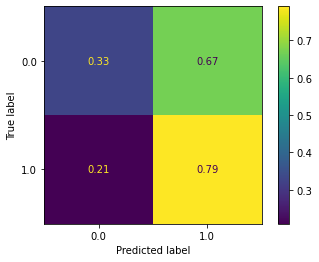

In [65]:
evaluate(dog_forest_model, X_train, X_test, y_train, y_test)

- This model is 4 points better than the decision tree that we used for dog predictions when evaluated on accuracy score.
- Precsion score dropped by a significant amount.
- Very good at predicting dogs that get adopted in less than a month.
- There is a class imbalance issue favoring dogs that get adopted in less than a month.
- False positive rate is almost 70% which is way too high for what we are trying to accomplish.

### Knn Models

#### Dog KNN Model

In [66]:
dog_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

In [67]:
# I want to focus on higher precision scores because a higher precision score will result in a lower false positive rate.
cross_validate(dog_knn, X_train, y_train, scoring='precision', return_train_score='true')

{'fit_time': array([0.00799799, 0.01057649, 0.01602554, 0.00808549, 0.02069902]),
 'score_time': array([0.04000735, 0.04046535, 0.031991  , 0.04012465, 0.03581405]),
 'test_score': array([0.69285714, 0.71326165, 0.69655172, 0.68864469, 0.72426471]),
 'train_score': array([0.77846975, 0.77280859, 0.77488789, 0.76828194, 0.78507194])}

In [68]:
dog_knn.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier', KNeighborsClassifier())])

Training Scores:
Train Accuracy: 0.7591160220994475
Train Precision: 0.7792114695340502
Train Recall: 0.8946502057613168
Train F1-Score: 0.8329501915708811
**********
Testing Scores:
Test Accuracy: 0.6241721854304636
Test Precision: 0.6881720430107527
Test Recall: 0.7960199004975125
Test F1-Score: 0.7381776239907727


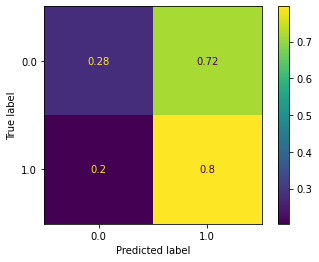

In [69]:
evaluate(dog_knn, X_train, X_test, y_train, y_test)

##### Knn Dog Model evaluation

- A little overfit but again it is very good at predicting the dogs that get adopted on time.
- False Positive rate is .72 which is very high.
- Again i think the class imbalance is affecting the false positive rate

#### Cat KNN

In [70]:
cat_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

In [71]:
cross_validate(cat_knn, X_train_cat, y_train_cat, scoring='precision', return_train_score='true')

{'fit_time': array([0.01598215, 0.01600528, 0.00799346, 0.00800228, 0.01600862]),
 'score_time': array([0.11346102, 0.12002444, 0.12788796, 0.12001109, 0.12000513]),
 'test_score': array([0.51987768, 0.50769231, 0.51428571, 0.485623  , 0.49707602]),
 'train_score': array([0.65539452, 0.67412935, 0.64912281, 0.67833333, 0.64889566])}

In [72]:
cat_knn.fit(X_train_cat, y_train_cat)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier', KNeighborsClassifier())])

Training Scores:
Train Accuracy: 0.6637635259963051
Train Precision: 0.6466753585397653
Train Recall: 0.5754060324825986
Train F1-Score: 0.6089625537139348
**********
Testing Scores:
Test Accuracy: 0.5443037974683544
Test Precision: 0.502127659574468
Test Recall: 0.4083044982698962
Test F1-Score: 0.45038167938931295


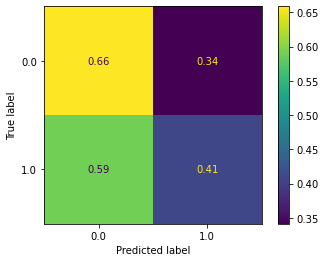

In [73]:
evaluate(cat_knn, X_train_cat, X_test_cat, y_train_cat, y_test_cat)

#### Cat KNN Evaluation

- Lower false positive rate of 34%
- It is pretty good at classifying cats that take longer than a month to get adopted
- precision and accuracy scores on test data are low only around 50 percent
- knn model is also performing better on training data

### Logistic Regression

#### Dog Logistic model

In [74]:
dog_log = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

In [75]:
cross_validate(dog_log, X_train, y_train, scoring='precision', return_train_score='true')

{'fit_time': array([0.04802179, 0.0399797 , 0.03199792, 0.04124522, 0.04000449]),
 'score_time': array([0.00800633, 0.00802302, 0.00800586, 0.        , 0.00811148]),
 'test_score': array([0.6993865 , 0.70807453, 0.67692308, 0.68195719, 0.70347003]),
 'train_score': array([0.70338983, 0.6994701 , 0.7154213 , 0.70592764, 0.70307692])}

In [76]:
dog_log.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier', LogisticRegression())])

Training Scores:
Train Accuracy: 0.6917127071823205
Train Precision: 0.7029030265596047
Train Recall: 0.9366255144032922
Train F1-Score: 0.8031051517290049
**********
Testing Scores:
Test Accuracy: 0.6804635761589404
Test Precision: 0.6960600375234521
Test Recall: 0.9228855721393034
Test F1-Score: 0.7935828877005349


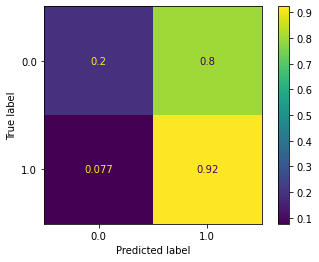

In [77]:
evaluate(dog_log, X_train, X_test, y_train, y_test)

##### Dog Logistic Regression Evaluation

- Very similar to our other dog models when looking at false positive rates
- The good thing about this model is that it is not overfit, it performs similarly on both test and training data
- This model gives us our best predictions on True Positives

##### Cat Logistic Regression Model 

In [78]:
cat_log = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

In [79]:
cross_validate(cat_log, X_train_cat, y_train_cat, scoring='precision', return_train_score='true')

{'fit_time': array([0.05602765, 0.05794477, 0.05406404, 0.05602312, 0.04866648]),
 'score_time': array([0.0080018 , 0.0080049 , 0.00800276, 0.        , 0.00800014]),
 'test_score': array([0.54347826, 0.54696133, 0.55778894, 0.56603774, 0.57446809]),
 'train_score': array([0.61138614, 0.59574468, 0.57718894, 0.6       , 0.60892388])}

In [80]:
cat_log.fit(X_train_cat, y_train_cat)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier', LogisticRegression())])

Training Scores:
Train Accuracy: 0.5964634468197414
Train Precision: 0.6040554962646745
Train Recall: 0.32830626450116007
Train F1-Score: 0.4254039834648628
ROC-AUC: 0.5489220873534599
**********
Testing Scores:
Test Accuracy: 0.5775316455696202
Test Precision: 0.5666666666666667
Test Recall: 0.3235294117647059
Test F1-Score: 0.41189427312775334
ROC-AUC: 0.5777732624008669


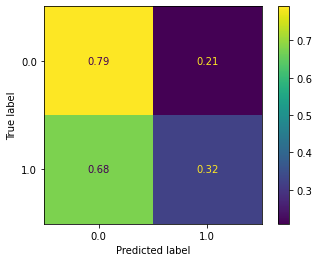

In [81]:
evaluate(cat_log, X_train_cat, X_test_cat, y_train_cat, y_test_cat, 'proba')

#### Cat Logistic Regression evaluation

- Logistic Regression gives us our lowest false positive rate for cats, we got it down to almost 20 percent here.
- Also the model performs similarly on training and test data.
- This is our best model yet for accurately predicting which cats wont be adopted within a month.

### XGBboost Models

#### Dog Model 

In [82]:
xgb_dog = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])

In [83]:
cross_validate(xgb_dog, X_train, y_train, scoring='precision', return_train_score='true')

{'fit_time': array([0.0719974 , 0.06400418, 0.06574059, 0.056005  , 0.05600452]),
 'score_time': array([0.00800085, 0.01600385, 0.00800157, 0.01600289, 0.0080018 ]),
 'test_score': array([0.70408163, 0.69257951, 0.69520548, 0.71481481, 0.70037453]),
 'train_score': array([0.84003575, 0.8240985 , 0.82728078, 0.82685512, 0.8321492 ])}

In [84]:
xgb_dog.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier',
                 XGBClassifier(base_...
          

Training Scores:
Train Accuracy: 0.8337016574585635
Train Precision: 0.8222849083215797
Train Recall: 0.9596707818930041
Train F1-Score: 0.885681731864793
**********
Testing Scores:
Test Accuracy: 0.6622516556291391
Test Precision: 0.7012195121951219
Test Recall: 0.8582089552238806
Test F1-Score: 0.7718120805369126


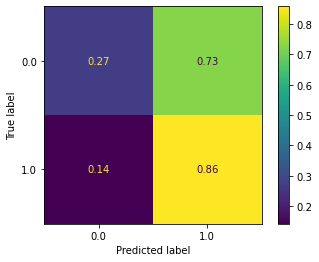

In [85]:
evaluate(xgb_dog, X_train, X_test, y_train, y_test)

##### Model Evaluation

- Model is very overfit
- False Positive rate is very high(73%)
- Very good at classifying the dogs that dont have trouble getting adopted

### Cat XGBboost Model

In [86]:
xgb_cat = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])

In [87]:
cross_validate(xgb_cat, X_train_cat, y_train_cat, scoring='precision', return_train_score='true')

{'fit_time': array([0.08800554, 0.08000708, 0.08000779, 0.07200718, 0.07200718]),
 'score_time': array([0.01600385, 0.01600289, 0.01600289, 0.00800085, 0.00800109]),
 'test_score': array([0.53281853, 0.51153846, 0.56862745, 0.51485149, 0.55102041]),
 'train_score': array([0.76328052, 0.74303684, 0.72687225, 0.73539519, 0.73487544])}

In [88]:
xgb_cat.fit(X_train_cat, y_train_cat)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier',
                 XGBClassifier(base_...
          

Training Scores:
Train Accuracy: 0.7102137767220903
Train Precision: 0.7325408618127786
Train Recall: 0.5719257540603249
Train F1-Score: 0.6423452768729643
ROC-AUC: 0.5199813258636787
**********
Testing Scores:
Test Accuracy: 0.5783227848101266
Test Precision: 0.5507900677200903
Test Recall: 0.42214532871972316
Test F1-Score: 0.4779627815866797
ROC-AUC: 0.5179609378848332


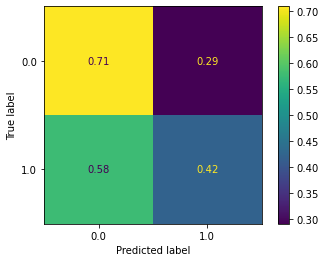

In [89]:
evaluate(xgb_cat, X_train_cat, X_test_cat, y_train_cat, y_test_cat, 'proba')

#### Model Evaluation

- Higher false positive rate than the Logistic Model
- Model is overfit
- Has a higher true positive rate than the Logistic Model, but we are focusing on flase positives because we want the identify the pets that really need help getting adopted.

## Model Tuning/Select Final Models

+ __Dog Predictions:__  The model that resulted in the lowest false positive rate was **Decision Tree** but it was very overfit
+ __Cat Predictions:__  gave us the lowest false positive  was **Logistic Regression** and it performed equally on both training and testing data

#### Dog Model

In [90]:
# Adjust the max-depth to reduce overfitting for Decision tree

dt_tuned = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=5))
])

In [91]:
cross_validate(dt_tuned, X_train, y_train, scoring='precision', return_train_score='true')

{'fit_time': array([0.00799179, 0.00800633, 0.00799942, 0.00800037, 0.00800204]),
 'score_time': array([0.00798488, 0.00801253, 0.00800109, 0.00800085, 0.00933933]),
 'test_score': array([0.6978852 , 0.70858896, 0.68343195, 0.67987805, 0.68571429]),
 'train_score': array([0.70842825, 0.7077728 , 0.70724421, 0.70278405, 0.71450858])}

- Great... training and test scores are alot closer than they were on our first decision tree.

In [92]:
dt_tuned.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier', DecisionTreeClassifier(max_depth=5))])

Training Scores:
Train Accuracy: 0.7066298342541436
Train Precision: 0.7085365853658536
Train Recall: 0.9563786008230453
Train F1-Score: 0.8140105078809107
ROC-AUC: 0.6391105578033682
**********
Testing Scores:
Test Accuracy: 0.6605960264900662
Test Precision: 0.6854990583804144
Test Recall: 0.9054726368159204
Test F1-Score: 0.7802786709539121
ROC-AUC: 0.5930003448106005


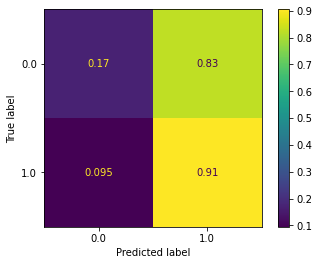

In [93]:
evaluate(dt_tuned, X_train, X_test, y_train, y_test, 'proba')

#### Model Evaluation 

- The model predicts dogs that get adopted on time at an extremely high rate, but also has a false positive rate of 82%
- It performs similarly on both test and train data
- Not really useful for our mission of identifying dogs that need help getting adopted 

In [94]:
# Try a grid search to see if I can improve the model
# I dont want the max depth to go to high, so I cap it at 11, to prevent overfitting
num_leafs = [1, 5, 10, 20, 50, 100]
depths = [1, 2, 3, 4, 5, 6, 7 ,8 ,9, 10, 11]

param_grid = [{'classifier__max_depth':depths,
              'classifier__min_samples_leaf':num_leafs}]

gs = GridSearchCV(estimator=dt_simple_model, param_grid=param_grid, scoring='precision', cv=10)
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['sexname',
                                                                          'basecolour',
                                                                          'breedname',
                                                                          'intakereason']),
                                                                        ('num',
                                                                         Pipeline(steps=[

In [95]:
gs.best_params_

{'classifier__max_depth': 10, 'classifier__min_samples_leaf': 10}

In [96]:
gs.best_score_

0.6992524530760559

In [97]:
dt_gs = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=10, min_samples_leaf=10))
])

In [98]:
cross_validate(dt_gs, X_train, y_train, scoring='precision', return_train_score='true')

{'fit_time': array([0.01601624, 0.01597905, 0.00799608, 0.01600146, 0.00800562]),
 'score_time': array([0.00799155, 0.00800991, 0.00800562, 0.00798368, 0.01068354]),
 'test_score': array([0.6977492 , 0.7114094 , 0.68253968, 0.68571429, 0.69283276]),
 'train_score': array([0.73233583, 0.73013245, 0.73894912, 0.72083981, 0.73693086])}

In [99]:
dt_gs.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=

Training Scores:
Train Accuracy: 0.7198895027624309
Train Precision: 0.7289780077619664
Train Recall: 0.9275720164609054
Train F1-Score: 0.8163708801159
ROC-AUC: 0.6928816958882318
**********
Testing Scores:
Test Accuracy: 0.6721854304635762
Test Precision: 0.703187250996016
Test Recall: 0.8781094527363185
Test F1-Score: 0.7809734513274336
ROC-AUC: 0.5932835820895522


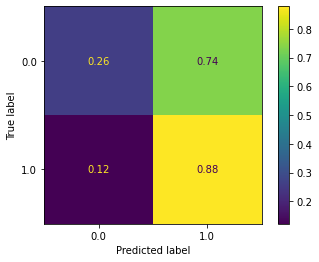

In [100]:
evaluate(dt_gs, X_train, X_test, y_train, y_test, roc_auc='proba')

#### Grid Searched Decision Tree Evaluation

- False positive rate dropped by 9 points which is good, but it is still too high.
- The model is not overfit so that is a plus, it should perform similarly on unseen data.
- Similarly to most of the dog models it performs equally

In [101]:
param_grid = {
    "classifier__n_neighbors": [3, 5, 7, 9, 11, 13, 15, 17, 19 ],
    "classifier__weights": ['uniform', 'distance'],
    "classifier__metric": ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(dog_knn, param_grid, verbose=1, cv=10, n_jobs=-1, scoring='precision')
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 329 out of 360 | elapsed:    5.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    5.1s finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['sexname',
                                                                          'basecolour',
                                                                          'breedname',
                                                                          'intakereason']),
                                                                        ('num',
                                                                         Pipeline(steps=[

In [102]:
grid_search.best_score_

0.7076506476162756

In [103]:
grid_search.best_params_

{'classifier__metric': 'euclidean',
 'classifier__n_neighbors': 3,
 'classifier__weights': 'distance'}

In [104]:
knn_tuned = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance'))
])

In [105]:
cross_validate(knn_tuned, X_train, y_train, scoring='precision', return_train_score='true')

{'fit_time': array([0.0156455 , 0.00802374, 0.00800562, 0.00800061, 0.00800395]),
 'score_time': array([0.02400327, 0.02400684, 0.02400398, 0.02400494, 0.03200269]),
 'test_score': array([0.69795918, 0.7148289 , 0.7       , 0.70661157, 0.68359375]),
 'train_score': array([0.98404255, 0.98412698, 0.98520085, 0.98308668, 0.98125   ])}

In [106]:
knn_tuned.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier',
                 KNeighborsClassifier(metric='eucl

Training Scores:
Train Accuracy: 0.9552486187845304
Train Precision: 0.9796954314720813
Train Recall: 0.9530864197530864
Train F1-Score: 0.9662077596996246
ROC-AUC: 0.9917716222291386
**********
Testing Scores:
Test Accuracy: 0.6307947019867549
Test Precision: 0.7156626506024096
Test Recall: 0.7388059701492538
Test F1-Score: 0.7270501835985312
ROC-AUC: 0.5832656026796709


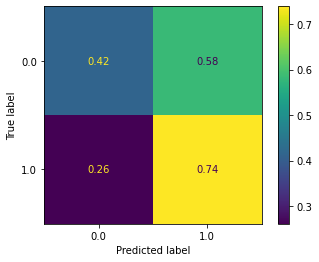

In [107]:
evaluate(knn_tuned, X_train, X_test, y_train, y_test, roc_auc='proba')

#### Cat Model/ Final Model Selection

In [110]:
cat_log.fit(X_train_cat, y_train_cat)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier', LogisticRegression())])

Training Scores:
Train Accuracy: 0.5964634468197414
Train Precision: 0.6040554962646745
Train Recall: 0.32830626450116007
Train F1-Score: 0.4254039834648628
**********
Testing Scores:
Test Accuracy: 0.5775316455696202
Test Precision: 0.5666666666666667
Test Recall: 0.3235294117647059
Test F1-Score: 0.41189427312775334


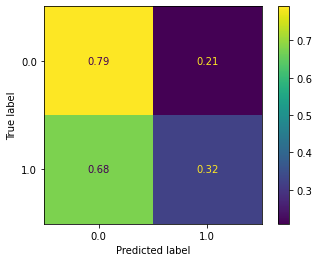

In [111]:
evaluate(cat_log, X_train_cat, X_test_cat, y_train_cat, y_test_cat)

- The Logistic Regression Model gave us our best results without being overfit.
- It had a very low false positive rate of only 21%

That model was not tuned so we can try altering the hyper parameters and seeing if that improves the results. 

In [ ]:
cat_log.get_params().keys()

In [112]:
log_param_grid = param_grid = [
    {'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']}]

gs_log = GridSearchCV(cat_log, param_grid=log_param_grid, scoring='precision', verbose=1, cv=5, n_jobs=-1)

gs_log.fit(X_train_cat, y_train_cat)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.7s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['sexname',
                                                                          'basecolour',
                                                                          'breedname',
                                                                          'intakereason']),
                                                                        ('num',
                                                                         Pipeline(steps=[(

In [113]:
gs_log.best_params_

{'classifier__C': 0.012742749857031334,
 'classifier__penalty': 'l1',
 'classifier__solver': 'liblinear'}

In [114]:
gs_log.best_score_

0.6166788517328996

In [115]:
cat_log_tuned = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty= 'l1', C=0.012742749857031334, solver='liblinear'))
])

In [116]:
cross_validate(cat_log_tuned, X_train_cat, y_train_cat, scoring='precision', return_train_score='true')

{'fit_time': array([0.02412558, 0.02374625, 0.01597023, 0.02373052, 0.01753831]),
 'score_time': array([0.01059675, 0.00800705, 0.00802207, 0.00799894, 0.00802994]),
 'test_score': array([0.56944444, 0.64912281, 0.66037736, 0.61428571, 0.59016393]),
 'train_score': array([0.62655602, 0.60546875, 0.60384615, 0.61316872, 0.61904762])}

In [117]:
cat_log_tuned.fit(X_train_cat, y_train_cat)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier',
                 LogisticRegression(C=0.0127427498

Training Scores:
Train Accuracy: 0.5637371338083927
Train Precision: 0.6134185303514377
Train Recall: 0.11136890951276102
Train F1-Score: 0.18851251840942562
ROC-AUC: 0.530301206902514
**********
Testing Scores:
Test Accuracy: 0.5474683544303798
Test Precision: 0.5294117647058824
Test Recall: 0.09342560553633218
Test F1-Score: 0.1588235294117647
ROC-AUC: 0.5437170582729915


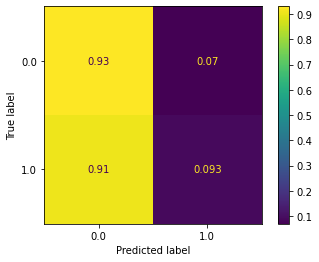

In [118]:
evaluate(cat_log_tuned, X_train_cat, X_test_cat, y_train_cat, y_test_cat, 'proba')

- While this model has the lowest false positive rate yet, it seems to just be guessing that every cat wont get adopted within a month. 
- If the model predicts that every cat needs help getting adopted then it does not really tell us anything.
- We will use the untuned logistic Regression model as our final model.

## Final Model Evaluation
- Test data on the holdout set

Training Scores:
Train Accuracy: 0.5964634468197414
Train Precision: 0.6040554962646745
Train Recall: 0.32830626450116007
Train F1-Score: 0.4254039834648628
**********
Testing Scores:
Test Accuracy: 0.5852017937219731
Test Precision: 0.5879828326180258
Test Recall: 0.3333333333333333
Test F1-Score: 0.42546583850931674


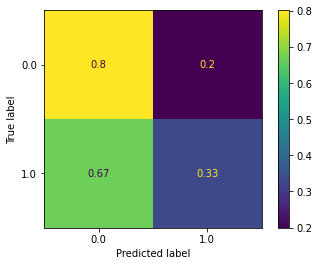

In [120]:
evaluate(cat_log, X_train_cat, X_hold_cat, y_train_cat, y_hold_cat)

+ It correctly classifies cats that take longer than a month to take adopted 80 percent of the time 
+ But only correctly classifies cats that get adopted in less than a month 33% of the time
+ This model has a vey low false positive rate(20%)

## Recommendations

## Conclusion

- The models still needs work but it can be used in conjunction with your domain knowledge to efficiently use resources to aid the dogs and cats that need the most help getting adopted. 

- Our cat model is very good at predicting which cats need help getting adopted in a timely manner but not very good at prediciting the cats that get adopted in a timely manner.

- The dog model is the opposite, it is very good at classifying the dogs that get adopted on time, but not too good at classifying the dogs that really need help.


- Our cat model will still misclassify cats that need help getting adopted 21% of the time.

## Future Work

- See if this model gets similar results on other shelters
- Analyze how the time of year that the animal entered the shelter effects adoption speed
- Experiment with the features and engineer them in different ways to improve scores